# Smaller Sample Sizes Normal Normal Log-Normal and Multivariate T, Multivariate Gamma, Inverse Gamma Simulations: MSE & Coverage

This notebook goes over the code needed to reproduce the results from the supplementary material MSE figure for smaller sample sizes (m = 250 and m = 500) in the first two simulations in the paper: the Normal Normal Log-Normal simulation and the Multivariate T, Multivariate Gamma, Inverse-Gamma simulation. 

The simulations were run in Julia version 1.4.0. The `randn!()` function changed in v1.5.0, and will produce different random numbers for the simulation. 

### Packages and Reproducibility

Julia allows for easy reproducibility, by including a `Manifest.toml` and `Project.toml` pair, the user can simply run `] activate .` and the correct environment with dependencies used will run.  

Note: We use the KNITRO solver in our analysis, which requires a KNITRO license. If you wish to run the analysis without it, you can use another solver, but the results will be slightly different. To do this, comment out the code each time it says `solver = KNITRO...` and replace it with `solver = Ipopt.IpoptSolver(print_level=0, watchdog_shortened_iter_trigger=3, max_iter=100)`.

In [2]:
]activate .

 Activating environment at `~/WiSER_Reproduce/simulations/Project.toml`


In [3]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9920X CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 8


In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, KNITRO
using Random, Roots, SpecialFunctions

function MSE(m::WSVarLmmModel, β::Vector, τ::Vector, Σγ::Matrix)
    mseβ = sum(abs2, m.β - β) / m.p
    mseτ = sum(abs2, m.τ[2:end] - τ[2:end]) / (m.l - 1)
    msevechLγ = sum(abs2, m.Σγ - Σγ) / abs2(m.q)
    return mseβ, mseτ, msevechLγ
end

function coverage!(m::WSVarLmmModel, trueparams::Vector, 
    intervals::Matrix, curcoverage::Vector)
    copyto!(intervals, confint(m))
    lbs = @views intervals[:, 1]
    ubs = @views intervals[:, 2]
    map!((val, lb, ub) -> val >= lb && 
        val <= ub, curcoverage, trueparams, lbs, ubs)
    return curcoverage
end

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
# true parameter values
βtrue = [ 0.1; 6.5; -3.5; 1.0; 5]
τtrue = [0.0; 0.5; -0.2; 0.5; 0.0]#[-1.5; 1.5; -0.5; 0.0; 0.0]
Σγ    = [1.5 0.5 0.3;
         0.5 1.0 0.2;
         0.3 0.2 0.5];
δγω   = [0.0; 0.0; 0.0] # for easier generation of (γ, ω)
σω    = 0.5
Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]
# parameters for Gamma random deviate ω
# If X ∼ Gamma(α, θ), then E[-ln(X)] = - ψ(α) - ln(θ), Var[-ln(X)] = ψ'(α).
# ωi = log(inv(X)) = - log(X)
# We want Var[ωi] = ψ'(α) = σω and E[ωi] = - ψ(α) - ln(θ) = 0
ωα    = Roots.find_zero(x -> trigamma(x) - σω, 1)
ωα > 1 || error("ωα needs to be >1 for the existence of mean of inverse-gamma")
ωθ    = exp(-digamma(ωα))
# parameters for Gamma random deviate γ
# If X ∼ Gamma(α, θ), then E[X] = αθ, Var[X] = αθ^2.
# We want Var[X] = 1 and don't care about mean (will shift it to 0)
γα    = 4             # shape parameter 
γθ    = sqrt(inv(γα)) # scale parameter
# degree of freedom for t
ν     = 6
# generate data
γ     = Vector{Float64}(undef, q)
z     = similar(γ) # hold vector of iid gamma

intervals = zeros(p + l, 2) #hold intervals
curcoverage = zeros(p + l) #hold current coverage resutls
trueparams = [βtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [250, 500]
ns = [10; 25; 50; 100; 1000]
nsims = 1000

#storage for results
βMseResults = ones(nsims * length(ns) * length(samplesizes))
τMseResults = ones(nsims * length(ns) * length(samplesizes))
ΣγMseResults = ones(nsims * length(ns) *  length(samplesizes))
βτcoverage = Matrix{Float64}(undef, p + l, nsims * length(ns) * length(samplesizes))
fittimes = zeros(nsims * length(ns) * length(samplesizes))
solver = KNITRO.KnitroSolver(outlev=0)

st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        y = Vector{Float64}(undef, ni)
        X = Matrix{Float64}(undef, ni, p)
        Z = Matrix{Float64}(undef, ni, q)
        W = Matrix{Float64}(undef, ni, l)
        for j in 1:nsims
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # first column intercept, remaining entries iid std normal
#                 X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                @views randn!(X[:, 2:p])
                # first column intercept, remaining entries iid std normal
#                 Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1
                @views randn!(Z[:, 2:q])
                # first column intercept, remaining entries iid std normal
#                 W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1
                @views randn!(W[:, 2:l])
                # generate ω ∼ log-inv-gamma(ωα, ωθ)
                ω = -log(rand(Gamma(ωα, ωθ)))
                # generate random effects: γ = Lγ * z
                # z is iid Gamma with variance 1 and shifted to have mean 0
                Distributions.rand!(Gamma(γα, γθ), z)
                z .-= γα * γθ # shift to have mean 0
                mul!(γ, Lγ, z)
                # generate y from t distribution (ν, μy, σ2ϵ)
                μy  = X * βtrue + Z * γ
                σ2ϵ = W * τtrue .+ dot(γ, lγω) .+ ω
                ysd = exp.(0.5 .* (σ2ϵ))
                # note: variance of T(ν) is ν / (ν - 2)
                y = μy + sqrt(((ν - 2) / ν)) .* ysd .* rand(TDist(ν), ni)
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            fittime = NaN
            try 
                if ni < 1000
                    fittime = @elapsed WiSER.fit!(vlmm, solver, parallel = false, runs = 3)
                else
                    fittime = @elapsed WiSER.fit!(vlmm, solver, runs = 1, parallel = false)
                end
                confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    fittime = @elapsed WiSER.fit!(vlmm, Ipopt.IpoptSolver(print_level=1, 
                        watchdog_shortened_iter_trigger=3, max_iter=100), parallel = false)
                        confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        fittime = @elapsed WiSER.fit!(vlmm, parallel = false)
                        confint(vlmm)
                    catch
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        βMseResults[currentind] = NaN
                        τMseResults[currentind] = NaN
                        ΣγMseResults[currentind] = NaN
                        βτcoverage[:, currentind] .= NaN
                        fittimes[currentind] = NaN
                        currentind += 1
                        continue
                    end
                end
            end
            coverage!(vlmm, trueparams, intervals, curcoverage)
            mseβ, mseτ, mseΣγ = MSE(vlmm, βtrue, τtrue, Σγ)

            #index = Int(nsims * length(ns) * (t - 1) + nsims * (k - 1) + j)
            global currentind
            @views copyto!(βτcoverage[:, currentind], curcoverage)
            βMseResults[currentind] = mseβ
            τMseResults[currentind] = mseτ
            ΣγMseResults[currentind] = mseΣγ
            fittimes[currentind] = fittime
            currentind += 1
        end
    end
end 
en = time()

@show en - st #seconds 

ftail = "sup_lowsamplesize_mvt_gamma_invgamma_$(nsims)reps_sim.csv"
writedlm("result_files/sup_sims/mse_beta_" * ftail, βMseResults, ',')
writedlm("result_files/sup_sims/mse_tau_" * ftail, τMseResults, ',')
writedlm("result_files/sup_sims/mse_Sigma_" * ftail, ΣγMseResults, ',')
writedlm("result_files/sup_sims/beta_tau_coverage_5betas_" * ftail, βτcoverage, ',')
writedlm("result_files/sup_sims/fittimes" * ftail, fittimes, ',')

In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, KNITRO
using Random, Roots, SpecialFunctions

function MSE(m::WSVarLmmModel, β::Vector, τ::Vector, Σγ::Matrix)
    mseβ = sum(abs2, m.β - β) / m.p
    mseτ = sum(abs2, m.τ[2:end] - τ[2:end]) / (m.l - 1)
    msevechLγ = sum(abs2, m.Σγ - Σγ) / abs2(m.q)
    return mseβ, mseτ, msevechLγ
end

function coverage!(m::WSVarLmmModel, trueparams::Vector, 
    intervals::Matrix, curcoverage::Vector)

    copyto!(intervals, confint(m))
    lbs = @views intervals[:, 1]
    ubs = @views intervals[:, 2]
    map!((val, lb, ub) -> val >= lb && 
        val <= ub, curcoverage, trueparams, lbs, ubs)
    return curcoverage
end

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
# true parameter values
βtrue = [ 0.1; 6.5; -3.5; 1.0; 5  ]
τtrue = [0.0; 0.5; -0.2; 0.5; 0.0]
Σγ    = [1.5 0.5 0.3;
         0.5 1.0 0.2;
         0.3 0.2 0.5];
δγω   = [0.2; 0.1; 0.05]
σω    = [0.5]
Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]
# generate data
γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

intervals = zeros(p + l, 2) #hold intervals
curcoverage = zeros(p + l) #hold current coverage resutls
trueparams = [βtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = [250, 500]
ns = [10; 25; 50; 100; 1000]
nsims = 1000

#storage for results
βMseResults = ones(nsims * length(ns) * length(samplesizes))
τMseResults = ones(nsims * length(ns) * length(samplesizes))
ΣγMseResults = ones(nsims * length(ns) *  length(samplesizes))
βτcoverage = Matrix{Float64}(undef, p + l, nsims * length(ns) * length(samplesizes))
fittimes = zeros(nsims * length(ns) * length(samplesizes))
solver = KNITRO.KnitroSolver(outlev=0)

st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        y = Vector{Float64}(undef, ni)
        X = Matrix{Float64}(undef, ni, p)
        Z = Matrix{Float64}(undef, ni, q)
        W = Matrix{Float64}(undef, ni, l)
        for j in 1:nsims
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # first column intercept, remaining entries iid std normal
#                 X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                @views randn!(X[:, 2:p])
                # first column intercept, remaining entries iid std normal
#                 Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1
                @views randn!(Z[:, 2:q])
                # first column intercept, remaining entries iid std normal
#                 W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1
                @views randn!(W[:, 2:l])
                # generate random effects: γω = Lγω * z
                mul!(γω, Lγω, randn!(z))
                # generate y
                μy = X * βtrue + Z * γω[1:q]
                @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
                y = ysd .* randn(ni) .+ μy
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            fittime = NaN
            try 
                if ni < 1000
                    fittime = @elapsed WiSER.fit!(vlmm, solver, parallel = false)
                else
                    fittime = @elapsed WiSER.fit!(vlmm, solver, runs = 1, parallel = false)
                end
                confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    fittime = @elapsed WiSER.fit!(vlmm, Ipopt.IpoptSolver(print_level=1, 
                        watchdog_shortened_iter_trigger=3, max_iter=100), parallel=false)
                        confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        fittime = @elapsed WiSER.fit!(vlmm, init = init_mom!(vlmm), parallel=false)
                        confint(vlmm)
                    catch
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        βMseResults[currentind] = NaN
                        τMseResults[currentind] = NaN
                        ΣγMseResults[currentind] = NaN
                        βτcoverage[:, currentind] .= NaN
                        fittimes[currentind] = NaN
                        currentind += 1
                        continue
                    end
                end
            end
            coverage!(vlmm, trueparams, intervals, curcoverage)
            mseβ, mseτ, mseΣγ = MSE(vlmm, βtrue, τtrue, Σγ)

            #index = Int(nsims * length(ns) * (t - 1) + nsims * (k - 1) + j)
            global currentind
            @views copyto!(βτcoverage[:, currentind], curcoverage)
            βMseResults[currentind] = mseβ
            τMseResults[currentind] = mseτ
            ΣγMseResults[currentind] = mseΣγ
            fittimes[currentind] = fittime
            currentind += 1
        end
    end
end 
en = time()

@show en - st #seconds 

ftail = "sup_lowsamplesize_normal_normal_lognormal_$(nsims)reps_sim.csv"
writedlm("result_files/sup_sims/mse_beta_" * ftail, βMseResults, ',')
writedlm("result_files/sup_sims/mse_tau_" * ftail, τMseResults, ',')
writedlm("result_files/sup_sims/mse_Sigma_" * ftail, ΣγMseResults, ',')
writedlm("result_files/sup_sims/beta_tau_coverage_5betas_" * ftail, βτcoverage, ',')
writedlm("result_files/sup_sims/fittimes" * ftail, fittimes, ',')

## Coverage
### Normal Normal Log Normal

In [5]:
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem
ENV["COLUMNS"]=800

βτcoverage = readdlm("result_files/sup_sims/beta_tau_coverage_5betas_sup_lowsamplesize_normal_normal_lognormal_1000reps_sim.csv", ',')
samplesizes = [250; 500]
ns = [10; 25; 50; 100; 1000]
nsims = 1000
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))


covdf = DataFrame(transpose(βτcoverage))
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
covdf = filter(row -> !any(isnan.([row[i] for i in length(row) - 2])), covdf)
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats)
ss_obs = unique("m: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]])])
deletecols!(covdfdisplay, p + 2)
covdfdisplay

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[5]:29
└ @ Core In[5]:29


,people_obs,β1,β2,β3,β4,β5,τ2,τ3,τ4,τ5
,String,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…
1,m: 250 ni: 10,"(0.948898, 0.006974)","(0.942886, 0.00734944)","(0.9499, 0.00690893)","(0.957916, 0.0063588)","(0.95491, 0.00657165)","(0.923848, 0.00840029)","(0.915832, 0.00879295)","(0.926854, 0.00824621)","(0.921844, 0.00850086)"
2,m: 250 ni: 25,"(0.946, 0.00715088)","(0.95, 0.00689547)","(0.944, 0.0072744)","(0.954, 0.00662781)","(0.947, 0.00708811)","(0.932, 0.00796489)","(0.936, 0.00774364)","(0.927, 0.00823035)","(0.941, 0.00745484)"
3,m: 250 ni: 50,"(0.941, 0.00745484)","(0.948, 0.00702462)","(0.943, 0.00733518)","(0.962, 0.00604918)","(0.943, 0.00733518)","(0.934, 0.0078553)","(0.935, 0.00779973)","(0.931, 0.00801893)","(0.95, 0.00689547)"
4,m: 250 ni: 100,"(0.944, 0.0072744)","(0.94, 0.00751375)","(0.945, 0.00721298)","(0.943, 0.00733518)","(0.941, 0.00745484)","(0.936, 0.00774364)","(0.942, 0.00739532)","(0.939, 0.00757208)","(0.946, 0.00715088)"
5,m: 250 ni: 1000,"(0.945, 0.00721298)","(0.961, 0.00612507)","(0.951, 0.00682976)","(0.956, 0.00648892)","(0.954, 0.00662781)","(0.943, 0.00733518)","(0.938, 0.00762982)","(0.938, 0.00762982)","(0.943, 0.00733518)"
6,m: 500 ni: 10,"(0.942943, 0.0073423)","(0.943944, 0.00728147)","(0.947948, 0.00703147)","(0.941942, 0.00740249)","(0.954955, 0.00656523)","(0.940941, 0.00746207)","(0.92993, 0.00808027)","(0.932933, 0.00791798)","(0.930931, 0.00802667)"
7,m: 500 ni: 25,"(0.948, 0.00702462)","(0.953, 0.00669596)","(0.947, 0.00708811)","(0.957, 0.00641811)","(0.959, 0.00627362)","(0.944, 0.0072744)","(0.94, 0.00751375)","(0.938, 0.00762982)","(0.942, 0.00739532)"
8,m: 500 ni: 50,"(0.946, 0.00715088)","(0.95, 0.00689547)","(0.952, 0.00676326)","(0.948, 0.00702462)","(0.959, 0.00627362)","(0.939, 0.00757208)","(0.943, 0.00733518)","(0.949, 0.00696042)","(0.944, 0.0072744)"
9,m: 500 ni: 100,"(0.957958, 0.00635258)","(0.935936, 0.00775113)","(0.937938, 0.00763721)","(0.947948, 0.00703147)","(0.946947, 0.00709501)","(0.943944, 0.00728147)","(0.940941, 0.00746207)","(0.951952, 0.00676987)","(0.942943, 0.0073423)"


In [7]:
using Printf   
println("\\begin{table}[ht]")
println("\\begin{center}")
println("\\begin{adjustbox}{width=\\textwidth}")
println("\\begin{tabular}{lcccccccccc}")
println("\\toprule")
println("\\multicolumn{1}{c}{\\,}&\\multicolumn{5}{c}{\$\\betabf\$}&\\multicolumn{4}{c}{\$\\taubf\$}\\\\\\cmidrule(lr){2-6}\\cmidrule(lr){7-10}")
println(" sample size: obs per & \$\\beta_1\$  & \$\\beta_2\$ & \$\\beta_3\$ & \$\\beta_4\$ & \$\\beta_5\$ & \$\\tau_2\$ & \$\\tau_3\$ & \$\\tau_4\$ & \$\\tau_5\$ \\\\\\midrule")
m, n = size(covdfdisplay)
for j in 1:m
    print(" $(covdfdisplay[j, 1])")
print(join([" & " * @sprintf("%.3f", covdfdisplay[j, i][1]) * " (" * @sprintf("%.3f", covdfdisplay[j, i][2]) * ") " for i in 2:n]))
    println(" \\\\ ")
end
println("\\bottomrule")
println("\\end{tabular}")
println("\\end{adjustbox}")
println("\\end{center}")
println("\\caption{Empirical coverage rate of 95\\% confidence intervals for the (Normal, Normal, Log-Normal) simulations with smaller sample sizes. Listed are the empirical coverage rates with standard errors in the parentheses based on 1000 replicates.}")
println("\\label{table:small_ss_coverage_table_normal_lognormal}")
println("\\end{table}%")

\begin{table}[ht]
\begin{center}
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{lcccccccccc}
\toprule
\multicolumn{1}{c}{\,}&\multicolumn{5}{c}{$\betabf$}&\multicolumn{4}{c}{$\taubf$}\\\cmidrule(lr){2-6}\cmidrule(lr){7-10}
 sample size: obs per & $\beta_1$  & $\beta_2$ & $\beta_3$ & $\beta_4$ & $\beta_5$ & $\tau_2$ & $\tau_3$ & $\tau_4$ & $\tau_5$ \\\midrule
 m: 250  ni: 10 & 0.949 (0.007)  & 0.943 (0.007)  & 0.950 (0.007)  & 0.958 (0.006)  & 0.955 (0.007)  & 0.924 (0.008)  & 0.916 (0.009)  & 0.927 (0.008)  & 0.922 (0.009)  \\ 
 m: 250  ni: 25 & 0.946 (0.007)  & 0.950 (0.007)  & 0.944 (0.007)  & 0.954 (0.007)  & 0.947 (0.007)  & 0.932 (0.008)  & 0.936 (0.008)  & 0.927 (0.008)  & 0.941 (0.007)  \\ 
 m: 250  ni: 50 & 0.941 (0.007)  & 0.948 (0.007)  & 0.943 (0.007)  & 0.962 (0.006)  & 0.943 (0.007)  & 0.934 (0.008)  & 0.935 (0.008)  & 0.931 (0.008)  & 0.950 (0.007)  \\ 
 m: 250  ni: 100 & 0.944 (0.007)  & 0.940 (0.008)  & 0.945 (0.007)  & 0.943 (0.007)  & 0.941 (0.007)  & 0.936 (0.00

### MvT Gamma Inv Gamma

In [8]:
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem
ENV["COLUMNS"]=800

βτcoverage = readdlm("result_files/sup_sims/beta_tau_coverage_5betas_sup_lowsamplesize_mvt_gamma_invgamma_1000reps_sim.csv", ',')
samplesizes = [250; 500]
ns = [10; 25; 50; 100; 1000]
nsims = 1000

covdf = DataFrame(transpose(βτcoverage))
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
covdf = filter(row -> !any(isnan.([row[i] for i in length(row) - 2])), covdf)
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats)
ss_obs = unique("m: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]])])
deletecols!(covdfdisplay, p + 2)
covdfdisplay

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[8]:29
└ @ Core In[8]:29


,people_obs,β1,β2,β3,β4,β5,τ2,τ3,τ4,τ5
,String,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…
1,m: 250 ni: 10,"(0.949648, 0.00694282)","(0.941591, 0.00744586)","(0.931521, 0.008019)","(0.947633, 0.0070728)","(0.946626, 0.00713669)","(0.882175, 0.0102362)","(0.90433, 0.00933888)","(0.89426, 0.00976329)","(0.892246, 0.00984473)"
2,m: 250 ni: 25,"(0.93662, 0.00773186)","(0.948692, 0.00700132)","(0.955734, 0.0065272)","(0.960765, 0.00616131)","(0.952716, 0.00673539)","(0.927565, 0.00822566)","(0.932596, 0.00795639)","(0.932596, 0.00795639)","(0.921529, 0.00853363)"
3,m: 250 ni: 50,"(0.942943, 0.0073423)","(0.948949, 0.0069672)","(0.940941, 0.00746207)","(0.934935, 0.00780727)","(0.95996, 0.00620595)","(0.936937, 0.00769445)","(0.933934, 0.00786289)","(0.931932, 0.00797257)","(0.932933, 0.00791798)"
4,m: 250 ni: 100,"(0.945838, 0.0071718)","(0.94985, 0.00691568)","(0.948847, 0.00698081)","(0.941825, 0.00741689)","(0.941825, 0.00741689)","(0.930792, 0.00804218)","(0.93681, 0.00770937)","(0.924774, 0.0083574)","(0.941825, 0.00741689)"
5,m: 250 ni: 1000,"(0.94, 0.00751375)","(0.95, 0.00689547)","(0.949, 0.00696042)","(0.934, 0.0078553)","(0.944, 0.0072744)","(0.941, 0.00745484)","(0.938, 0.00762982)","(0.947, 0.00708811)","(0.926, 0.00828206)"
6,m: 500 ni: 10,"(0.952859, 0.00671562)","(0.950853, 0.00684979)","(0.951856, 0.00678311)","(0.943831, 0.00729565)","(0.94985, 0.00691568)","(0.917753, 0.00870548)","(0.91675, 0.00875361)","(0.914744, 0.00884875)","(0.922768, 0.00845891)"
7,m: 500 ni: 25,"(0.93487, 0.00781483)","(0.947896, 0.00703832)","(0.940882, 0.00746931)","(0.942886, 0.00734944)","(0.966934, 0.00566295)","(0.932866, 0.00792564)","(0.932866, 0.00792564)","(0.931864, 0.00798027)","(0.93487, 0.00781483)"
8,m: 500 ni: 50,"(0.941884, 0.00740969)","(0.95491, 0.00657165)","(0.946894, 0.00710192)","(0.942886, 0.00734944)","(0.945892, 0.00716481)","(0.940882, 0.00746931)","(0.935872, 0.00775863)","(0.940882, 0.00746931)","(0.952906, 0.00670905)"
9,m: 500 ni: 100,"(0.946, 0.00715088)","(0.943, 0.00733518)","(0.954, 0.00662781)","(0.944, 0.0072744)","(0.962, 0.00604918)","(0.953, 0.00669596)","(0.93, 0.00807249)","(0.935, 0.00779973)","(0.94, 0.00751375)"


In [9]:
using Printf   
println("\\begin{table}[ht]")
println("\\begin{center}")
println("\\begin{adjustbox}{width=\\textwidth}")
println("\\begin{tabular}{lcccccccccc}")
println("\\toprule")
println("\\multicolumn{1}{c}{\\,}&\\multicolumn{5}{c}{\$\\betabf\$}&\\multicolumn{4}{c}{\$\\taubf\$}\\\\\\cmidrule(lr){2-6}\\cmidrule(lr){7-10}")
println(" sample size: obs per & \$\\beta_1\$  & \$\\beta_2\$ & \$\\beta_3\$ & \$\\beta_4\$ & \$\\beta_5\$ & \$\\tau_2\$ & \$\\tau_3\$ & \$\\tau_4\$ & \$\\tau_5\$ \\\\\\midrule")
m, n = size(covdfdisplay)
for j in 1:m
    print(" $(covdfdisplay[j, 1])")
print(join([" & " * @sprintf("%.3f", covdfdisplay[j, i][1]) * " (" * @sprintf("%.3f", covdfdisplay[j, i][2]) * ") " for i in 2:n]))
    println(" \\\\ ")
end
println("\\bottomrule")
println("\\end{tabular}")
println("\\end{adjustbox}")
println("\\end{center}")
println("\\caption{Empirical coverage rate of 95\\% confidence intervals for the (Multivariate T, Multivariate Gamma, Inverse Gamma) simulations with smaller sample sizes. Listed are the empirical coverage rates with standard errors in the parentheses based on 1000 replicates.}")
println("\\label{table:small_ss_coverage_table_mvt_gamma}")
println("\\end{table}%")

\begin{table}[ht]
\begin{center}
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{lcccccccccc}
\toprule
\multicolumn{1}{c}{\,}&\multicolumn{5}{c}{$\betabf$}&\multicolumn{4}{c}{$\taubf$}\\\cmidrule(lr){2-6}\cmidrule(lr){7-10}
 sample size: obs per & $\beta_1$  & $\beta_2$ & $\beta_3$ & $\beta_4$ & $\beta_5$ & $\tau_2$ & $\tau_3$ & $\tau_4$ & $\tau_5$ \\\midrule
 m: 250  ni: 10 & 0.950 (0.007)  & 0.942 (0.007)  & 0.932 (0.008)  & 0.948 (0.007)  & 0.947 (0.007)  & 0.882 (0.010)  & 0.904 (0.009)  & 0.894 (0.010)  & 0.892 (0.010)  \\ 
 m: 250  ni: 25 & 0.937 (0.008)  & 0.949 (0.007)  & 0.956 (0.007)  & 0.961 (0.006)  & 0.953 (0.007)  & 0.928 (0.008)  & 0.933 (0.008)  & 0.933 (0.008)  & 0.922 (0.009)  \\ 
 m: 250  ni: 50 & 0.943 (0.007)  & 0.949 (0.007)  & 0.941 (0.007)  & 0.935 (0.008)  & 0.960 (0.006)  & 0.937 (0.008)  & 0.934 (0.008)  & 0.932 (0.008)  & 0.933 (0.008)  \\ 
 m: 250  ni: 100 & 0.946 (0.007)  & 0.950 (0.007)  & 0.949 (0.007)  & 0.942 (0.007)  & 0.942 (0.007)  & 0.931 (0.00

## MSE

In [16]:
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem
ENV["COLUMNS"]=1000

βMseresultrobust = vec(readdlm("result_files/sup_sims/mse_beta_sup_lowsamplesize_mvt_gamma_invgamma_1000reps_sim.csv", ','))
τMseresultrobust = vec(readdlm("result_files/sup_sims/mse_tau_sup_lowsamplesize_mvt_gamma_invgamma_1000reps_sim.csv", ','))
ΣMseresultrobust = vec(readdlm("result_files/sup_sims/mse_Sigma_sup_lowsamplesize_mvt_gamma_invgamma_1000reps_sim.csv", ','))
βτcoveragerobust = readdlm("result_files/sup_sims/beta_tau_coverage_5betas_sup_lowsamplesize_mvt_gamma_invgamma_1000reps_sim.csv", ',')


samplesizesrobust = [250; 500]
nsrobust = [10; 25; 50; 100; 1000]
nsimsrobust = 1000

βMseresultnorm = vec(readdlm("result_files/sup_sims/mse_beta_sup_lowsamplesize_normal_normal_lognormal_1000reps_sim.csv", ','))
τMseresultnorm = vec(readdlm("result_files/sup_sims/mse_tau_sup_lowsamplesize_normal_normal_lognormal_1000reps_sim.csv", ','))
ΣMseresultnorm = vec(readdlm("result_files/sup_sims/mse_Sigma_sup_lowsamplesize_normal_normal_lognormal_1000reps_sim.csv", ','))
βτcoveragenorm = readdlm("result_files/sup_sims/beta_tau_coverage_5betas_sup_lowsamplesize_normal_normal_lognormal_1000reps_sim.csv", ',')


samplesizesnorm = [250; 500]
nsnorm = [10; 25; 50; 100; 1000]
nsimsnorm = 1000

p = 5; l = 5
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresultrobust, τmse = τMseresultrobust, Σγmse = ΣMseresultrobust, 
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

p = 5; l = 5
sample_sizesnorm = repeat(string.(samplesizesnorm), inner = nsimsnorm * length(nsnorm))
obs_sizesnorm = repeat(string.(nsnorm), inner = nsimsnorm, outer = length(samplesizesnorm))
msedfnorm = DataFrame(βmse = βMseresultnorm, τmse = τMseresultnorm, Σγmse = ΣMseresultnorm, 
    samplesize = sample_sizesnorm, obssize = obs_sizesnorm)

#rename to make parsing easier for R.

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "taumse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedfnormR = deepcopy(msedfnorm)
rename!(msedfnormR, ["betamse"
    "taumse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :taumse]; msedfrobustR[!, :Sigmamse];  
    msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [repeat(msedfrobustR[!, :obssize], 3); repeat(msedfnormR[!, :obssize], 3)]
samplesize = [repeat(msedfrobustR[!, :samplesize], 3); repeat(msedfnormR[!, :samplesize], 3)]

parameters = [repeat(string.([:beta, :tau, :Sigma]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust)); 
    repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = [repeat(["MvT Gamma Inverse Gamma"], 3 * nsimsrobust * length(nsrobust) * length(samplesizesrobust));
repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#84 of the 60,000 rows (28 of 20,000 simulations) did not converge, filter out
# count(isnan.(msedfR.mse))
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
# msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00258502,10,250,beta,MvT Gamma Inverse Gamma
2,0.00700012,10,250,beta,MvT Gamma Inverse Gamma
3,0.000432594,10,250,beta,MvT Gamma Inverse Gamma
4,0.000465492,10,250,beta,MvT Gamma Inverse Gamma
5,0.00105278,10,250,beta,MvT Gamma Inverse Gamma
6,0.00225747,10,250,beta,MvT Gamma Inverse Gamma
7,0.000822002,10,250,beta,MvT Gamma Inverse Gamma
8,0.000746425,10,250,beta,MvT Gamma Inverse Gamma
9,0.000359514,10,250,beta,MvT Gamma Inverse Gamma


In [17]:
filter(x -> x.mse > 1000, msedfR) #look at high MSE results, most in Sigma (to be expected), 5 in tau 

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,1525.23,10,250,tau,MvT Gamma Inverse Gamma
2,1004.57,10,500,tau,MvT Gamma Inverse Gamma
3,32345.6,25,500,tau,MvT Gamma Inverse Gamma
4,4109.18,100,500,tau,MvT Gamma Inverse Gamma
5,4.09805e15,10,250,Sigma,MvT Gamma Inverse Gamma
6,1.22737e6,10,250,Sigma,MvT Gamma Inverse Gamma
7,3.18074e6,10,250,Sigma,MvT Gamma Inverse Gamma
8,2.06155e6,50,250,Sigma,MvT Gamma Inverse Gamma
9,3.15378e22,50,250,Sigma,MvT Gamma Inverse Gamma


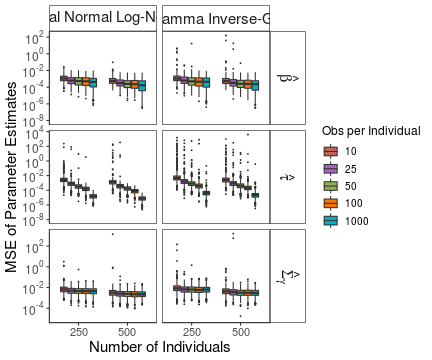

RObject{VecSxp}


In [21]:
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(facetscales)
library(data.table)

msedfR <- data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "tau",y_min := 10^-8]
msedfR[parameters == "tau",y_max := 10^3]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize <- factor(msedfR$obssize, levels = c('10', '25', '50', '100', '1000'))
msedfR$samplesize <- factor(msedfR$samplesize, levels = c('250', '500'))
msedfR$parameters <- factor(msedfR$parameters, levels = c('beta', 'tau', 'Sigma'),
    labels = c(beta = expression(hat(bold(beta))), tau = expression(hat(bold(tau))), 
            Sigma = expression(hat(bold(Sigma))[bold(gamma)])))
msedfR$robust <- factor(msedfR$robust, levels = c('Normal Normal Log-Normal', 'MvT Gamma Inverse Gamma'),
    labels = c(expression(paste("Normal Normal Log-Normal")), expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot <- ggplot(msedfR[msedfR$mse < 10^4, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [22]:
R"""
ggsave('result_files/smallsamplesizes_msefacetplot.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{NilSxp}
NULL
